# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

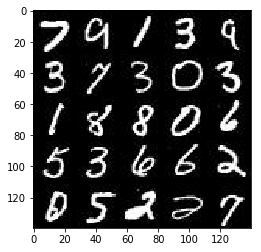

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

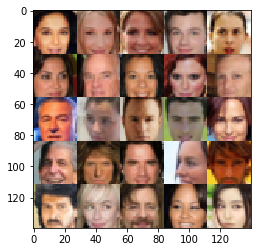

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(
        tf.float32, 
        (None, image_width, image_height, image_channels),
        'real_inputs'
    )
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):        
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        flattened = tf.reshape(conv3, (-1, 4096))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        conv1 = tf.layers.dense(z, 2*2*512)
        conv1 = tf.reshape(conv1, (-1, 2, 2, 512))
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 5, 2, 'VALID')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)

        logits = tf.layers.conv2d_transpose(
            conv3, out_channel_dim, 5, 2, 'SAME'
        )
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1
    ).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    print_step_every = 10
    show_output_every = 100
    num_images_to_show = 25
    
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim
    )
    
    d_loss, g_loss = model_loss(
        real_input,
        z_input,
        img_channels
    )
    d_opt, g_opt = model_opt(
        d_loss,
        g_loss,
        learning_rate,
        beta1
    )
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2.0
                steps += 1
                
                batch_z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: batch_z_sample, lr: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={
                        z_input: batch_z_sample, lr: learning_rate
                })
                
                if steps % print_step_every == 0:
                    train_loss_d = d_loss.eval({
                        z_input: batch_z_sample, real_input: batch_images
                    })
                    train_loss_g = g_loss.eval({
                        z_input: batch_z_sample
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_output_every == 0:
                    show_generator_output(sess, num_images_to_show, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 1.0368
Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 21.8448
Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 2.0708... Generator Loss: 1.5217
Epoch 1/2... Discriminator Loss: 2.5212... Generator Loss: 0.2226
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 4.5622... Generator Loss: 8.3537
Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 0.5807
Epoch 1/2... Discriminator Loss: 0.1985... Generator Loss: 3.4170
Epoch 1/2... Discriminator Loss: 2.6970... Generator Loss: 0.6827


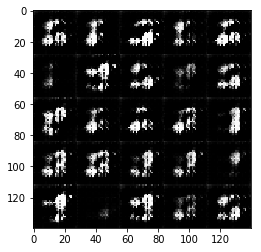

Epoch 1/2... Discriminator Loss: 0.3592... Generator Loss: 2.1590
Epoch 1/2... Discriminator Loss: 2.7123... Generator Loss: 0.2998
Epoch 1/2... Discriminator Loss: 0.1646... Generator Loss: 3.0865
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 5.5971
Epoch 1/2... Discriminator Loss: 0.2603... Generator Loss: 3.1594
Epoch 1/2... Discriminator Loss: 0.3359... Generator Loss: 2.2101
Epoch 1/2... Discriminator Loss: 1.5069... Generator Loss: 1.0451
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 2.2750
Epoch 1/2... Discriminator Loss: 0.4548... Generator Loss: 1.7413
Epoch 1/2... Discriminator Loss: 0.2189... Generator Loss: 2.9766


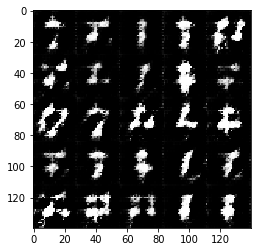

Epoch 1/2... Discriminator Loss: 0.3288... Generator Loss: 2.4506
Epoch 1/2... Discriminator Loss: 1.9417... Generator Loss: 0.4554
Epoch 1/2... Discriminator Loss: 0.7270... Generator Loss: 1.1333
Epoch 1/2... Discriminator Loss: 0.5944... Generator Loss: 3.8255
Epoch 1/2... Discriminator Loss: 0.2438... Generator Loss: 2.3435
Epoch 1/2... Discriminator Loss: 0.4200... Generator Loss: 4.2411
Epoch 1/2... Discriminator Loss: 0.6360... Generator Loss: 1.2538
Epoch 1/2... Discriminator Loss: 0.8488... Generator Loss: 2.0468
Epoch 1/2... Discriminator Loss: 0.3684... Generator Loss: 1.8788
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.7743


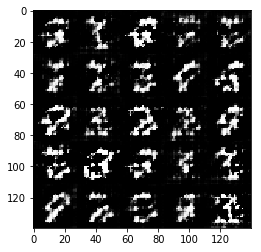

Epoch 1/2... Discriminator Loss: 0.6441... Generator Loss: 1.4606
Epoch 1/2... Discriminator Loss: 2.2064... Generator Loss: 0.3443
Epoch 1/2... Discriminator Loss: 0.3946... Generator Loss: 1.9789
Epoch 1/2... Discriminator Loss: 0.2921... Generator Loss: 2.5909
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 1.3285
Epoch 1/2... Discriminator Loss: 0.6835... Generator Loss: 1.3463
Epoch 1/2... Discriminator Loss: 0.6794... Generator Loss: 1.4771
Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 1.0099
Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 0.3757
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 1.0577


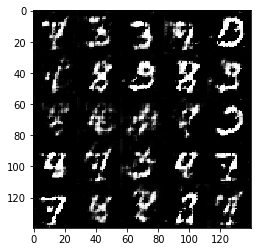

Epoch 1/2... Discriminator Loss: 0.8159... Generator Loss: 1.7726
Epoch 1/2... Discriminator Loss: 0.7981... Generator Loss: 1.5507
Epoch 1/2... Discriminator Loss: 0.9358... Generator Loss: 0.7497
Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 1.5146... Generator Loss: 0.4735
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 0.8973
Epoch 1/2... Discriminator Loss: 0.9145... Generator Loss: 1.8674
Epoch 1/2... Discriminator Loss: 0.9682... Generator Loss: 0.9799
Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 2.1203
Epoch 1/2... Discriminator Loss: 0.7945... Generator Loss: 1.9035


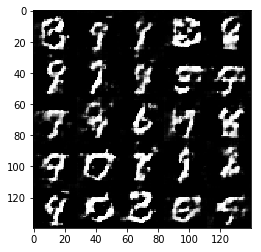

Epoch 1/2... Discriminator Loss: 0.8929... Generator Loss: 1.2408
Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 1.2643
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 2.0015
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.6680... Generator Loss: 0.4348
Epoch 1/2... Discriminator Loss: 0.8338... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 0.7641... Generator Loss: 1.1599
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 2.2908
Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 0.9000
Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 1.3473


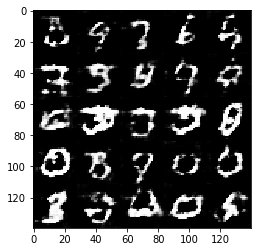

Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 0.8071... Generator Loss: 1.7733
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 2.2541
Epoch 1/2... Discriminator Loss: 0.8534... Generator Loss: 0.9752
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 0.5394
Epoch 1/2... Discriminator Loss: 0.9332... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 1.7478... Generator Loss: 3.5350
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 1.2776
Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 0.5841


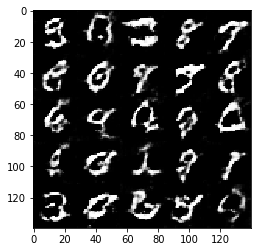

Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.4532
Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.5988
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 1.4157
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 0.9359
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 0.8793
Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 0.9101... Generator Loss: 1.0937
Epoch 1/2... Discriminator Loss: 1.6783... Generator Loss: 0.3279


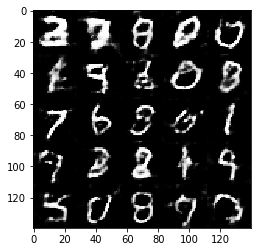

Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 2.3245
Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 0.9974
Epoch 1/2... Discriminator Loss: 0.8652... Generator Loss: 1.1324
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 2.9450
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 0.7114
Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 1.8037
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 1.0543
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 2.0387
Epoch 1/2... Discriminator Loss: 1.7047... Generator Loss: 0.2614


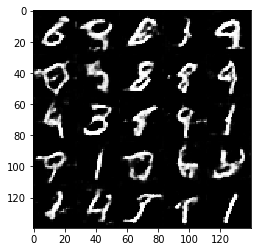

Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 2.2175
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 0.9036
Epoch 2/2... Discriminator Loss: 2.2671... Generator Loss: 0.1759
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.5622
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 1.0735
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 0.9197
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 0.5647
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 1.0727


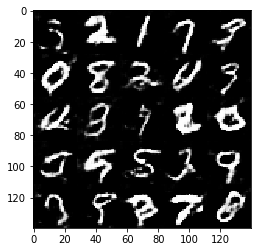

Epoch 2/2... Discriminator Loss: 1.0702... Generator Loss: 0.7117
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 0.9033
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 0.6567
Epoch 2/2... Discriminator Loss: 1.1684... Generator Loss: 0.5507
Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 0.3997
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 1.8116
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 0.6308
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 0.9315
Epoch 2/2... Discriminator Loss: 2.4923... Generator Loss: 0.1369
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.2768


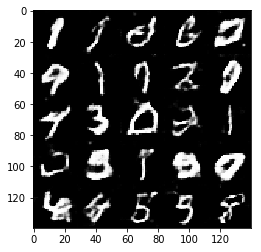

Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.6528
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 2.8481... Generator Loss: 0.0919
Epoch 2/2... Discriminator Loss: 0.8103... Generator Loss: 1.7401
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 1.6157
Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 0.9834
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 1.0037
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 2.3647
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 1.3129
Epoch 2/2... Discriminator Loss: 1.2839... Generator Loss: 0.4895


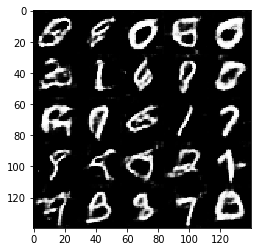

Epoch 2/2... Discriminator Loss: 1.6692... Generator Loss: 0.2914
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.5903
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.0134
Epoch 2/2... Discriminator Loss: 0.8566... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 1.0312
Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.5210
Epoch 2/2... Discriminator Loss: 1.5445... Generator Loss: 0.3554
Epoch 2/2... Discriminator Loss: 1.5128... Generator Loss: 0.3948
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 0.8030


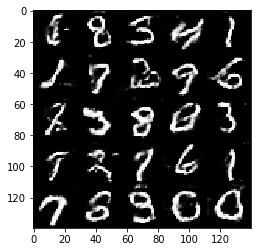

Epoch 2/2... Discriminator Loss: 0.7176... Generator Loss: 2.1102
Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 2.3458
Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 0.7065


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 1.3222
Epoch 1/1... Discriminator Loss: 0.3127... Generator Loss: 1.7665
Epoch 1/1... Discriminator Loss: 0.1436... Generator Loss: 6.1887
Epoch 1/1... Discriminator Loss: 0.2676... Generator Loss: 1.9607
Epoch 1/1... Discriminator Loss: 0.1153... Generator Loss: 3.0174
Epoch 1/1... Discriminator Loss: 0.1303... Generator Loss: 3.6853
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 14.4029
Epoch 1/1... Discriminator Loss: 0.2657... Generator Loss: 9.8353
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 13.7466


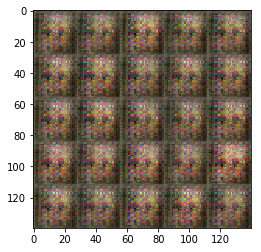

Epoch 1/1... Discriminator Loss: 0.1694... Generator Loss: 3.8965
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 9.2026
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 8.5180
Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 9.1001
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 0.6531... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 5.0000
Epoch 1/1... Discriminator Loss: 1.6874... Generator Loss: 7.6230
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 2.1311


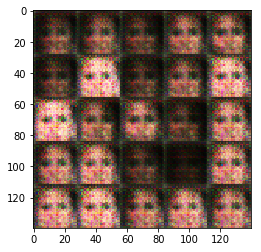

Epoch 1/1... Discriminator Loss: 0.2866... Generator Loss: 2.0740
Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 3.9730
Epoch 1/1... Discriminator Loss: 0.2793... Generator Loss: 3.2451
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 2.3071
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.3020
Epoch 1/1... Discriminator Loss: 0.4633... Generator Loss: 1.7240
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 0.4741... Generator Loss: 1.7694
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.7610


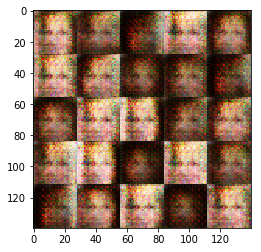

Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 2.2407
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 1.5209
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.1760
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 2.2586
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 1.9328
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.3966


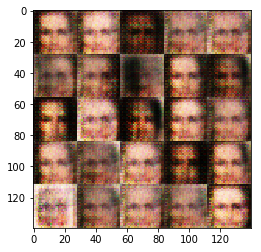

Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 1.7278
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 1.6507
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 2.2837
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 1.3696
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 2.2616
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 2.2172
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 1.7265


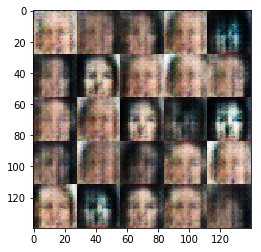

Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.2692
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.5690
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.6050
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.8502
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 0.9900


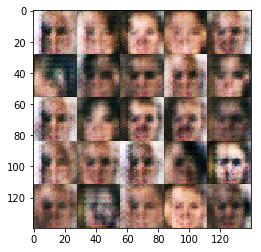

Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 1.5186
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 1.4258
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.5982
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.6838
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.3878


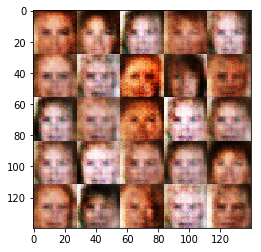

Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.6471
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.4528
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 1.9577
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 1.4804
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 2.2435
Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 1.6587
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 1.6750
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.7792


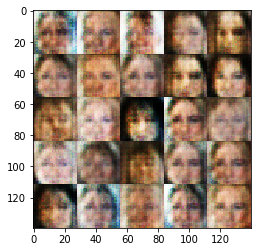

Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 1.7811
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.3079
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 2.1343
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.4519
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 2.8803


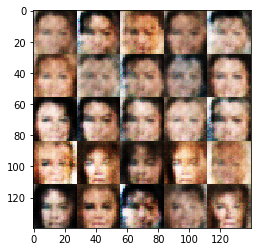

Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.6531
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.8527
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.5596
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.4049
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.4228
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.5224


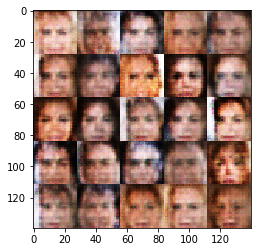

Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.4279
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.9743


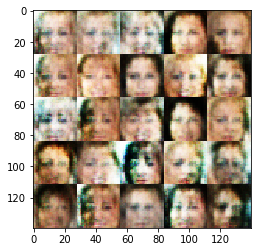

Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.5117
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 1.9469
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.9354
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.6909


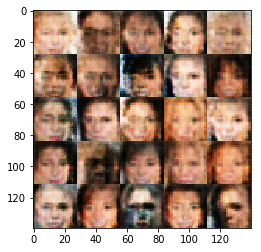

Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.1459
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.6680


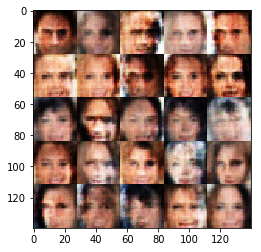

Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.7712
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.1811
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 0.9454


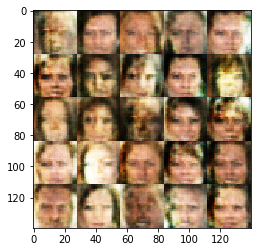

Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.4272
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 2.0727
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.7109


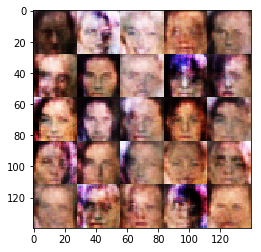

Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.6978
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 0.9730


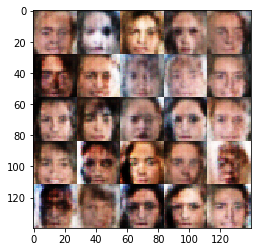

Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.3529
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.6217
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.5348
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.9935
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.3681
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.1097


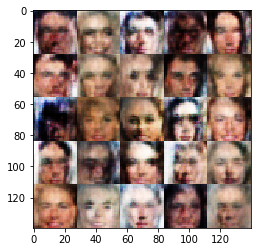

Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.7480
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.5863
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.3817
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.6792


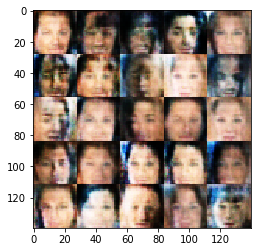

Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.7107
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 1.5756
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 2.0113
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 2.0695
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.4327


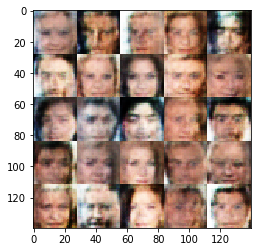

Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.7414
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.6870


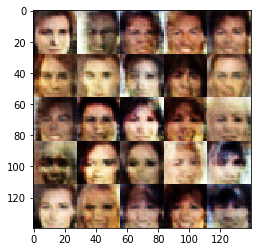

Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.6461
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 1.7661
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 2.1922
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 0.9371


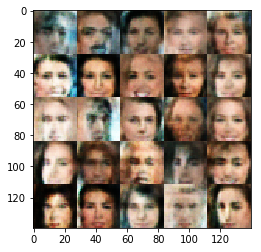

Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 1.8473
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.4560
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.5298
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.0593


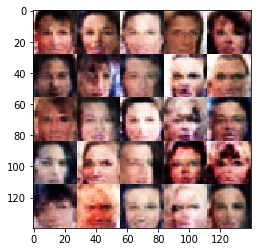

Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.1742
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.6774
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 0.8862


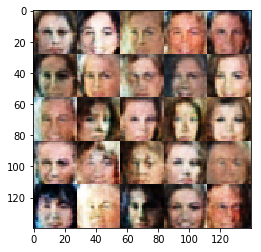

Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.6662


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.